# 07.3d: Token Distinguishability Analysis

**Goal:** Analyze how close tokens are to bfloat16 indistinguishability.

Given a region defined by spherical coordinates (latitude, longitude, radius), this notebook:
1. Identifies all tokens in that region
2. Loads their original gamma vectors (promoted from bfloat16)
3. Computes pairwise component-wise separations
4. Compares to bfloat16 ULP spacing to determine proximity to quantization degeneracy

**Question:** Are tokens in dense clusters barely distinguishable (2-3× ULP) or comfortably separated (10-20× ULP) in the original bfloat16 representation?

## Parameters

In [1]:
# ============================================================================
# DATA FILES
# ============================================================================

TENSOR_DIR = "../data/tensors"

# Gamma vectors (promoted from bfloat16 to float32)
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma"

# Basis vectors (defines coordinate system)
BASIS_FILE = "pca_basis_vectors.safetensors"
BASIS_KEYS = {
    'north': '1',      # +Z: north (out of equatorial plane)
    'meridian': '2',   # +X: prime meridian (0° lon)
    'equinox': '3'     # +Y: equinox (90° lon)
}

# Viewpoint (for centering)
VIEWPOINT_FILE = "gamma_centroid_mu.safetensors"
VIEWPOINT_KEY = "mu"

# Black hole mask (optional)
MASK_FILE = "black_hole_mask.safetensors"
MASK_KEY = "mask"

# ============================================================================
# REGION OF INTEREST (Spherical coordinates)
# ============================================================================

# Latitude range (degrees, -90 to +90)
LAT_MIN = 23.0
LAT_MAX = 24.0

# Longitude range (degrees, -180 to +180)
LON_MIN = 164.0
LON_MAX = 165.0

# Radius range (Euclidean distance from viewpoint)
R_MIN = 0.1222
R_MAX = 0.1224

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import combinations

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading gamma matrix...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
N, d = gamma.shape
print(f"  Shape: ({N:,}, {d:,})")
print(f"  Dtype: {gamma.dtype}")
print()

Loading gamma matrix...
  Shape: (151,936, 2,560)
  Dtype: torch.float32



In [4]:
print("Loading basis vectors...")
basis_data = load_file(data_dir / BASIS_FILE)
north_vector = basis_data[BASIS_KEYS['north']]
meridian_vector = basis_data[BASIS_KEYS['meridian']]
equinox_vector = basis_data[BASIS_KEYS['equinox']]
print(f"  North (+Z): {north_vector.shape}")
print(f"  Meridian (+X): {meridian_vector.shape}")
print(f"  Equinox (+Y): {equinox_vector.shape}")
print()

Loading basis vectors...
  North (+Z): torch.Size([2560])
  Meridian (+X): torch.Size([2560])
  Equinox (+Y): torch.Size([2560])



In [5]:
print("Loading viewpoint...")
viewpoint_data = load_file(data_dir / VIEWPOINT_FILE)
viewpoint = viewpoint_data[VIEWPOINT_KEY]
print(f"  Shape: {viewpoint.shape}")
print(f"  Norm: {torch.norm(viewpoint).item():.6f}")
print()

Loading viewpoint...
  Shape: torch.Size([2560])
  Norm: 0.304777



In [6]:
print("Loading mask...")
mask_data = load_file(data_dir / MASK_FILE)
mask = mask_data[MASK_KEY]
n_masked = mask.sum().item()
print(f"  Shape: {mask.shape}")
print(f"  Tokens to exclude: {n_masked:,} ({n_masked/N*100:.2f}%)")
print()

Loading mask...
  Shape: torch.Size([151936])
  Tokens to exclude: 2,100 (1.38%)



## Step 2: Compute Spherical Coordinates

In [7]:
print("Computing spherical coordinates...\n")

# Center at viewpoint
gamma_centered = gamma - viewpoint

# Project onto basis vectors
x = gamma_centered @ meridian_vector  # +X (prime meridian)
y = gamma_centered @ equinox_vector   # +Y (equinox)
z = gamma_centered @ north_vector     # +Z (north)

# Compute radius (full 3D distance)
r = torch.sqrt(x**2 + y**2 + z**2)

# Compute longitude (φ)
lon_rad = torch.atan2(y, x)
lon_deg = torch.rad2deg(lon_rad)

# Compute latitude (θ) using arcsin of normalized z
# lat = arcsin(z/r), but handle r=0 case
lat_rad = torch.asin(torch.clamp(z / (r + 1e-10), -1, 1))
lat_deg = torch.rad2deg(lat_rad)

print("Spherical coordinates computed.")
print()
print(f"Radius statistics:")
print(f"  Range: [{r.min().item():.6f}, {r.max().item():.6f}]")
print()
print(f"Longitude statistics:")
print(f"  Range: [{lon_deg.min().item():.2f}°, {lon_deg.max().item():.2f}°]")
print()
print(f"Latitude statistics:")
print(f"  Range: [{lat_deg.min().item():.2f}°, {lat_deg.max().item():.2f}°]")
print()

Computing spherical coordinates...

Spherical coordinates computed.

Radius statistics:
  Range: [0.002472, 1.095257]

Longitude statistics:
  Range: [-179.99°, 180.00°]

Latitude statistics:
  Range: [-89.92°, 89.68°]



## Step 3: Identify Tokens in Region

In [8]:
print(f"Identifying tokens in region...\n")

# Create filter
region_filter = (
    ~mask &  # Exclude black holes
    (lat_deg >= LAT_MIN) & (lat_deg <= LAT_MAX) &
    (lon_deg >= LON_MIN) & (lon_deg <= LON_MAX) &
    (r >= R_MIN) & (r <= R_MAX)
)

# Get token IDs
token_ids = torch.where(region_filter)[0]
n_tokens = len(token_ids)

print(f"Region: lat [{LAT_MIN}°, {LAT_MAX}°], lon [{LON_MIN}°, {LON_MAX}°], r [{R_MIN:.4f}, {R_MAX:.4f}]")
print(f"Tokens found: {n_tokens:,}")
print()

if n_tokens == 0:
    print("⚠️  No tokens found in specified region. Adjust parameters.")
elif n_tokens > 1000:
    print("⚠️  Very large token set. Pairwise analysis may be slow.")
    print(f"   Estimated pairs: {n_tokens * (n_tokens - 1) // 2:,}")

print()
print(f"Token IDs (first 20): {token_ids[:20].tolist()}")
if n_tokens > 20:
    print(f"  ... and {n_tokens - 20} more")
print()

Identifying tokens in region...

Region: lat [23.0°, 24.0°], lon [164.0°, 165.0°], r [0.1222, 0.1224]
Tokens found: 113


Token IDs (first 20): [27487, 83971, 123821, 123952, 124084, 124178, 124530, 124608, 124707, 124769, 124860, 125047, 125071, 125125, 125458, 125527, 125655, 125687, 125869, 126316]
  ... and 93 more



## Step 4: Extract Vectors for Analysis

In [9]:
# Extract gamma vectors for these tokens
vectors = gamma[token_ids]

print(f"Extracted {len(vectors):,} vectors for analysis.")
print(f"  Shape: {vectors.shape}")
print(f"  Dtype: {vectors.dtype}")
print()

Extracted 113 vectors for analysis.
  Shape: torch.Size([113, 2560])
  Dtype: torch.float32



## Step 5: Compute Pairwise Component-wise Distances

In [10]:
print("Computing pairwise component-wise distances...\n")

# For each pair of vectors, compute max component-wise difference (L∞ distance)
n = len(vectors)
n_pairs = n * (n - 1) // 2

print(f"Number of pairs: {n_pairs:,}")

if n_pairs > 100000:
    print("⚠️  Large number of pairs. This may take a while...")

# Compute all pairwise differences
# Strategy: expand to [n, 1, d] and [1, n, d], subtract, take abs, then max over d
v1 = vectors.unsqueeze(1)  # [n, 1, d]
v2 = vectors.unsqueeze(0)  # [1, n, d]

# Component-wise absolute differences [n, n, d]
diffs = torch.abs(v1 - v2)

# L∞ distance (max component difference) [n, n]
l_inf_distances = diffs.max(dim=2)[0]

# Extract upper triangle (ignore diagonal and duplicate pairs)
triu_indices = torch.triu_indices(n, n, offset=1)
pairwise_l_inf = l_inf_distances[triu_indices[0], triu_indices[1]]

print(f"\nL∞ distance statistics (max component-wise difference):")
print(f"  Min: {pairwise_l_inf.min().item():.6e}")
print(f"  Max: {pairwise_l_inf.max().item():.6e}")
print(f"  Mean: {pairwise_l_inf.mean().item():.6e}")
print(f"  Median: {pairwise_l_inf.median().item():.6e}")
print()

Computing pairwise component-wise distances...

Number of pairs: 6,328

L∞ distance statistics (max component-wise difference):
  Min: 7.450581e-09
  Max: 9.765625e-04
  Mean: 4.245408e-05
  Median: 3.051758e-05



## Step 6: Analyze Typical Component Magnitudes

In [11]:
print("Analyzing component magnitudes...\n")

# Get component-wise statistics across all selected vectors
component_abs = torch.abs(vectors)

print(f"Component magnitude statistics:")
print(f"  Min: {component_abs.min().item():.6e}")
print(f"  Max: {component_abs.max().item():.6e}")
print(f"  Mean: {component_abs.mean().item():.6e}")
print(f"  Median: {component_abs.median().item():.6e}")
print()

# Typical magnitude for ULP calculation
typical_mag = component_abs.median().item()
print(f"Using median component magnitude for ULP calculation: {typical_mag:.6e}")
print()

Analyzing component magnitudes...

Component magnitude statistics:
  Min: 9.872019e-08
  Max: 8.056641e-02
  Mean: 4.804358e-03
  Median: 3.585815e-03

Using median component magnitude for ULP calculation: 3.585815e-03



## Step 7: Compute bfloat16 ULP Spacing

bfloat16 format:
- 1 sign bit
- 8 exponent bits (same as float32)
- 7 mantissa bits (vs 23 in float32)

ULP (unit in last place) for a value `x`:
```
ulp(x) = 2^(floor(log2(|x|)) - 6)
```

The `-6` comes from having 7 mantissa bits (2^7 = 128 distinguishable values between powers of 2).

In [12]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP spacing for value x."""
    if x == 0:
        return 2.0 ** (-133)  # Minimum subnormal
    exponent = np.floor(np.log2(np.abs(x)))
    return 2.0 ** (exponent - 6)

# Compute ULP for typical component magnitude
ulp = bfloat16_ulp(typical_mag)

print(f"bfloat16 ULP spacing at typical magnitude ({typical_mag:.6e}):")
print(f"  ULP: {ulp:.6e}")
print()

# Compare minimum L∞ distance to ULP
min_l_inf = pairwise_l_inf.min().item()
separation_ratio = min_l_inf / ulp

print(f"Minimum component-wise separation: {min_l_inf:.6e}")
print(f"Separation in ULP units: {separation_ratio:.2f}× ULP")
print()

if separation_ratio < 2:
    print("⚠️  VERY CLOSE to bfloat16 degeneracy (< 2× ULP)")
    print("   These tokens are barely distinguishable in bfloat16.")
elif separation_ratio < 5:
    print("⚠️  Close to bfloat16 degeneracy (2-5× ULP)")
    print("   Marginal separation in bfloat16 representation.")
elif separation_ratio < 10:
    print("✓ Moderately separated (5-10× ULP)")
    print("  Distinguishable but not comfortably separated.")
else:
    print("✓ Comfortably separated (> 10× ULP)")
    print("  Well-distinguished in bfloat16 representation.")
print()

bfloat16 ULP spacing at typical magnitude (3.585815e-03):
  ULP: 3.051758e-05

Minimum component-wise separation: 7.450581e-09
Separation in ULP units: 0.00× ULP

⚠️  VERY CLOSE to bfloat16 degeneracy (< 2× ULP)
   These tokens are barely distinguishable in bfloat16.



## Step 8: Distribution of Separations

Creating separation distribution histogram...



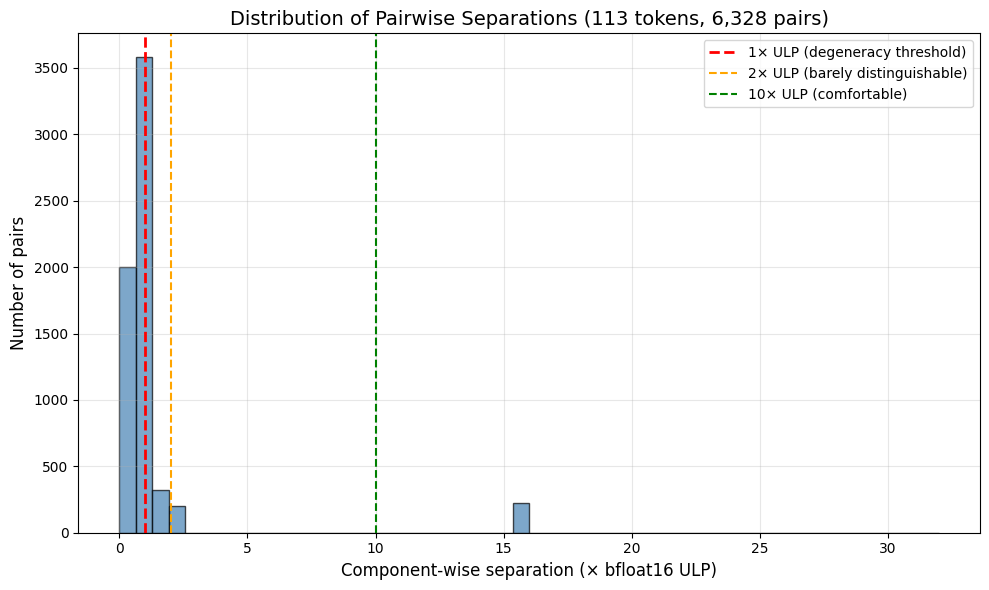

Separation distribution (in ULP units):
  < 2× ULP (barely distinguishable): 5,905 pairs (93.3%)
  2-10× ULP (moderate): 200 pairs (3.2%)
  > 10× ULP (comfortable): 223 pairs (3.5%)



In [13]:
print("Creating separation distribution histogram...\n")

# Convert to ULP units
separations_in_ulp = pairwise_l_inf.cpu().numpy() / ulp

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Histogram
counts, bins, patches = ax.hist(separations_in_ulp, bins=50, 
                                 color='steelblue', alpha=0.7, edgecolor='black')

# Mark critical thresholds
ax.axvline(1, color='red', linestyle='--', linewidth=2, label='1× ULP (degeneracy threshold)')
ax.axvline(2, color='orange', linestyle='--', linewidth=1.5, label='2× ULP (barely distinguishable)')
ax.axvline(10, color='green', linestyle='--', linewidth=1.5, label='10× ULP (comfortable)')

ax.set_xlabel('Component-wise separation (× bfloat16 ULP)', fontsize=12)
ax.set_ylabel('Number of pairs', fontsize=12)
ax.set_title(f'Distribution of Pairwise Separations ({n_tokens:,} tokens, {n_pairs:,} pairs)', 
             fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Separation distribution (in ULP units):")
print(f"  < 2× ULP (barely distinguishable): {(separations_in_ulp < 2).sum():,} pairs ({(separations_in_ulp < 2).sum() / len(separations_in_ulp) * 100:.1f}%)")
print(f"  2-10× ULP (moderate): {((separations_in_ulp >= 2) & (separations_in_ulp < 10)).sum():,} pairs ({((separations_in_ulp >= 2) & (separations_in_ulp < 10)).sum() / len(separations_in_ulp) * 100:.1f}%)")
print(f"  > 10× ULP (comfortable): {(separations_in_ulp >= 10).sum():,} pairs ({(separations_in_ulp >= 10).sum() / len(separations_in_ulp) * 100:.1f}%)")
print()

## Summary

In [14]:
print("=" * 60)
print("TOKEN DISTINGUISHABILITY SUMMARY")
print("=" * 60)
print()
print(f"Region: lat [{LAT_MIN}°, {LAT_MAX}°], lon [{LON_MIN}°, {LON_MAX}°], r [{R_MIN:.4f}, {R_MAX:.4f}]")
print(f"Tokens analyzed: {n_tokens:,}")
print(f"Pairwise comparisons: {n_pairs:,}")
print()
print(f"Component magnitude (median): {typical_mag:.6e}")
print(f"bfloat16 ULP at this magnitude: {ulp:.6e}")
print()
print(f"Minimum separation: {min_l_inf:.6e} ({separation_ratio:.2f}× ULP)")
print(f"Maximum separation: {pairwise_l_inf.max().item():.6e} ({pairwise_l_inf.max().item() / ulp:.2f}× ULP)")
print(f"Mean separation: {pairwise_l_inf.mean().item():.6e} ({pairwise_l_inf.mean().item() / ulp:.2f}× ULP)")
print()
print("=" * 60)

TOKEN DISTINGUISHABILITY SUMMARY

Region: lat [23.0°, 24.0°], lon [164.0°, 165.0°], r [0.1222, 0.1224]
Tokens analyzed: 113
Pairwise comparisons: 6,328

Component magnitude (median): 3.585815e-03
bfloat16 ULP at this magnitude: 3.051758e-05

Minimum separation: 7.450581e-09 (0.00× ULP)
Maximum separation: 9.765625e-04 (32.00× ULP)
Mean separation: 4.245408e-05 (1.39× ULP)

